In [16]:
import pandas as pd
import numpy as np
import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


# Sleep

In [17]:
sleep = pd.read_csv('../data/nt_y_fitb_slp_d.csv')
sleep = sleep[sleep['eventname'] == '2_year_follow_up_y_arm_1']

print("Sleep data columns:", sleep.columns.tolist())


Sleep data columns: ['src_subject_id', 'eventname', 'fit_ss_sleepdate', 'fit_ss_wkno', 'fit_ss_weekday', 'fit_ss_weekend_ind', 'fit_ss_protocol_date', 'fit_ss_protocol_wear', 'fit_ss_first_inbed_minutes', 'fit_ss_first_sleep_minutes', 'fit_ss_outbed_minutes', 'fit_ss_wakeup_minutes', 'fit_ss_sleepperiod_minutes', 'fit_ss_wake_minutes', 'fit_ss_light_minutes', 'fit_ss_deep_minutes', 'fit_ss_rem_minutes', 'fit_ss_wake_count', 'fit_ss_avg_hr_wake', 'fit_ss_avg_hr_light', 'fit_ss_avg_hr_deep', 'fit_ss_avg_hr_rem']


In [18]:
demographic_data = ['src_subject_id', 'eventname']
average_sleep_data = ['fit_ss_sleepperiod_minutes', 'fit_ss_sleepdate', 'fit_ss_wake_minutes', 'fit_ss_light_minutes', 'fit_ss_deep_minutes', 'fit_ss_rem_minutes', 'fit_ss_wake_count',   'fit_ss_avg_hr_light', 'fit_ss_avg_hr_deep', 'fit_ss_avg_hr_rem', 'fit_ss_avg_hr_wake']

# Filter the sleep data to include only the demographic and average sleep columns
filtered_sleep_avg = sleep[demographic_data + average_sleep_data]

# Basic data exploration
print("Dataset shape:", filtered_sleep_avg.shape)
print("\nUnique subjects:", filtered_sleep_avg['src_subject_id'].nunique())
print("Unique events:", filtered_sleep_avg['eventname'].nunique())

# Check for multiple records per subject/event
records_per_subject_event = filtered_sleep_avg.groupby(['src_subject_id', 'eventname']).size()
print(f"\nRecords per subject/event - Min: {records_per_subject_event.min()}, Max: {records_per_subject_event.max()}")


Dataset shape: (83194, 13)

Unique subjects: 6078
Unique events: 1

Records per subject/event - Min: 1, Max: 159


In [19]:
# Check for unrealistic values
sleep_cols = ['fit_ss_sleepperiod_minutes', 'fit_ss_wake_minutes', 'fit_ss_light_minutes',
              'fit_ss_deep_minutes', 'fit_ss_rem_minutes']

for col in sleep_cols:
    print(f"\n{col}:")
    print(f"  Range: {filtered_sleep_avg[col].min():.1f} - {filtered_sleep_avg[col].max():.1f}")
    print(f"  Negative values: {(filtered_sleep_avg[col] < 0).sum()}")

# Check heart rate ranges
hr_cols = ['fit_ss_avg_hr_wake', 'fit_ss_avg_hr_light', 'fit_ss_avg_hr_deep', 'fit_ss_avg_hr_rem']
for col in hr_cols:
    print(f"\n{col}: {filtered_sleep_avg[col].min():.1f} - {filtered_sleep_avg[col].max():.1f}")


fit_ss_sleepperiod_minutes:
  Range: 0.5 - 4018.0
  Negative values: 0

fit_ss_wake_minutes:
  Range: 0.0 - 701.5
  Negative values: 0

fit_ss_light_minutes:
  Range: 0.5 - 2657.5
  Negative values: 0

fit_ss_deep_minutes:
  Range: 0.0 - 572.0
  Negative values: 0

fit_ss_rem_minutes:
  Range: 0.0 - 1025.5
  Negative values: 0

fit_ss_avg_hr_wake: 43.0 - 130.0

fit_ss_avg_hr_light: 41.0 - 121.0

fit_ss_avg_hr_deep: 40.0 - 139.0

fit_ss_avg_hr_rem: 41.0 - 124.0


In [20]:
# Define realistic ranges based on sleep research
def clean_sleep_data(df):
    print(f"Starting with {len(df)} records")

    # 1. Sleep period: 3-16 hours (180-960 minutes)
    df = df[(df['fit_ss_sleepperiod_minutes'] >= 180) &
            (df['fit_ss_sleepperiod_minutes'] <= 960)]
    print(f"After sleep period filter (3-16h): {len(df)} records")

    # 2. Wake minutes during sleep: 0-3 hours (0-180 minutes)
    df = df[(df['fit_ss_wake_minutes'] >= 0) &
            (df['fit_ss_wake_minutes'] <= 180)]
    print(f"After wake minutes filter (0-3h): {len(df)} records")

    # 3. Light sleep: 0-12 hours (0-720 minutes)
    df = df[(df['fit_ss_light_minutes'] >= 0) &
            (df['fit_ss_light_minutes'] <= 720)]
    print(f"After light sleep filter (0-12h): {len(df)} records")

    # 4. Deep sleep: 0-4 hours (0-240 minutes)
    df = df[(df['fit_ss_deep_minutes'] >= 0) &
            (df['fit_ss_deep_minutes'] <= 240)]
    print(f"After deep sleep filter (0-4h): {len(df)} records")

    # 5. REM sleep: 0-4 hours (0-240 minutes)
    df = df[(df['fit_ss_rem_minutes'] >= 0) &
            (df['fit_ss_rem_minutes'] <= 240)]
    print(f"After REM sleep filter (0-4h): {len(df)} records")

    # 6. Heart rates look reasonable, but let's be conservative: 35-150 bpm
    hr_cols = ['fit_ss_avg_hr_wake', 'fit_ss_avg_hr_light', 'fit_ss_avg_hr_deep', 'fit_ss_avg_hr_rem']
    for col in hr_cols:
        if col in df.columns:
            df = df[(df[col] >= 35) & (df[col] <= 150)]
    print(f"After heart rate filters (35-150 bpm): {len(df)} records")

    return df

# Apply the cleaning
cleaned_sleep_data = clean_sleep_data(filtered_sleep_avg.copy())

Starting with 83194 records
After sleep period filter (3-16h): 82643 records
After wake minutes filter (0-3h): 82642 records
After light sleep filter (0-12h): 82642 records
After deep sleep filter (0-4h): 82640 records
After REM sleep filter (0-4h): 82628 records
After heart rate filters (35-150 bpm): 82556 records


In [21]:
# Check if sleep stages make sense relative to sleep period
def validate_sleep_stages(df):
    print(f"\nValidating sleep stage consistency...")

    # Calculate total sleep stages
    df['total_sleep_stages'] = (df['fit_ss_light_minutes'] +
                               df['fit_ss_deep_minutes'] +
                               df['fit_ss_rem_minutes'])

    # Sleep stages + wake time should roughly equal sleep period
    df['calculated_sleep_period'] = df['total_sleep_stages'] + df['fit_ss_wake_minutes']
    df['period_difference'] = abs(df['fit_ss_sleepperiod_minutes'] - df['calculated_sleep_period'])

    print(f"Period difference stats:")
    print(df['period_difference'].describe())

    # Remove records where difference is more than 60 minutes (accounting for measurement errors)
    df_consistent = df[df['period_difference'] <= 60]
    print(f"Records with consistent sleep stages: {len(df_consistent)} (removed {len(df) - len(df_consistent)})")

    # Clean up temporary columns
    df_consistent = df_consistent.drop(['total_sleep_stages', 'calculated_sleep_period', 'period_difference'], axis=1)

    return df_consistent

# Apply consistency validation
final_cleaned_data = validate_sleep_stages(cleaned_sleep_data)


Validating sleep stage consistency...
Period difference stats:
count    82556.000000
mean        57.878059
std         18.406038
min          2.500000
25%         45.000000
50%         57.000000
75%         69.500000
max        178.500000
Name: period_difference, dtype: float64
Records with consistent sleep stages: 47376 (removed 35180)


In [22]:
# Summary of cleaning results
print(f"\n=== CLEANING SUMMARY ===")
print(f"Original records: {len(filtered_sleep_avg)}")
print(f"Final cleaned records: {len(final_cleaned_data)}")
print(f"Records removed: {len(filtered_sleep_avg) - len(final_cleaned_data)} ({((len(filtered_sleep_avg) - len(final_cleaned_data))/len(filtered_sleep_avg)*100):.1f}%)")

# Check new ranges after cleaning
print(f"\n=== NEW DATA RANGES ===")
sleep_cols = ['fit_ss_sleepperiod_minutes', 'fit_ss_wake_minutes', 'fit_ss_light_minutes',
              'fit_ss_deep_minutes', 'fit_ss_rem_minutes']

for col in sleep_cols:
    print(f"{col}: {final_cleaned_data[col].min():.1f} - {final_cleaned_data[col].max():.1f} minutes")

# Update your main dataset
filtered_sleep_avg = final_cleaned_data.copy()


=== CLEANING SUMMARY ===
Original records: 83194
Final cleaned records: 47376
Records removed: 35818 (43.1%)

=== NEW DATA RANGES ===
fit_ss_sleepperiod_minutes: 180.0 - 816.0 minutes
fit_ss_wake_minutes: 2.5 - 60.0 minutes
fit_ss_light_minutes: 45.5 - 475.5 minutes
fit_ss_deep_minutes: 0.5 - 202.5 minutes
fit_ss_rem_minutes: 1.0 - 235.0 minutes


# Descriptive analysis

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Basic descriptive statistics for all numeric columns
numeric_cols = ['fit_ss_sleepperiod_minutes', 'fit_ss_wake_minutes', 'fit_ss_light_minutes',
               'fit_ss_deep_minutes', 'fit_ss_rem_minutes', 'fit_ss_wake_count',
               'fit_ss_avg_hr_wake', 'fit_ss_avg_hr_light', 'fit_ss_avg_hr_deep', 'fit_ss_avg_hr_rem']

desc_stats = filtered_sleep_avg[numeric_cols].describe()

# Convert minutes to hours for better interpretation
sleep_minutes_cols = ['fit_ss_sleepperiod_minutes', 'fit_ss_wake_minutes', 'fit_ss_light_minutes',
                     'fit_ss_deep_minutes', 'fit_ss_rem_minutes']

for col in sleep_minutes_cols:
    hours_col = col.replace('_minutes', '_hours')
    filtered_sleep_avg[hours_col] = filtered_sleep_avg[col] / 60

hours_desc = filtered_sleep_avg[[col.replace('_minutes', '_hours') for col in sleep_minutes_cols]].describe()

In [25]:
print("\n=== DATASET OVERVIEW ===")
print(f"Total records: {len(filtered_sleep_avg):,}")
print(f"Unique subjects: {filtered_sleep_avg['src_subject_id'].nunique():,}")
print(f"Unique events: {filtered_sleep_avg['eventname'].nunique()}")
print(f"Event types: {filtered_sleep_avg['eventname'].unique()}")

# Records per subject/event
records_per_combo = filtered_sleep_avg.groupby(['src_subject_id', 'eventname']).size()
print(f"\nRecords per subject/event combination:")
print(f"  Mean: {records_per_combo.mean():.1f} days")
print(f"  Median: {records_per_combo.median():.1f} days")
print(f"  Range: {records_per_combo.min()} - {records_per_combo.max()} days")

# Date range analysis
if 'fit_ss_sleepdate' in filtered_sleep_avg.columns:
    filtered_sleep_avg['fit_ss_sleepdate'] = pd.to_datetime(filtered_sleep_avg['fit_ss_sleepdate'])
    print(f"\nDate range: {filtered_sleep_avg['fit_ss_sleepdate'].min().date()} to {filtered_sleep_avg['fit_ss_sleepdate'].max().date()}")
    print(f"Study duration: {(filtered_sleep_avg['fit_ss_sleepdate'].max() - filtered_sleep_avg['fit_ss_sleepdate'].min()).days} days")


=== DATASET OVERVIEW ===
Total records: 47,376
Unique subjects: 5,862
Unique events: 1
Event types: ['2_year_follow_up_y_arm_1']

Records per subject/event combination:
  Mean: 8.1 days
  Median: 7.0 days
  Range: 1 - 125 days

Date range: 2018-11-10 to 2022-04-13
Study duration: 1250 days


In [26]:
print("\n=== SLEEP ARCHITECTURE ANALYSIS ===")

# Calculate sleep efficiency and stage percentages
filtered_sleep_avg['sleep_efficiency'] = ((filtered_sleep_avg['fit_ss_sleepperiod_minutes'] -
                                          filtered_sleep_avg['fit_ss_wake_minutes']) /
                                         filtered_sleep_avg['fit_ss_sleepperiod_minutes'] * 100)

# Sleep stage percentages of total sleep time
total_sleep_time = (filtered_sleep_avg['fit_ss_light_minutes'] +
                   filtered_sleep_avg['fit_ss_deep_minutes'] +
                   filtered_sleep_avg['fit_ss_rem_minutes'])

filtered_sleep_avg['light_sleep_pct'] = filtered_sleep_avg['fit_ss_light_minutes'] / total_sleep_time * 100
filtered_sleep_avg['deep_sleep_pct'] = filtered_sleep_avg['fit_ss_deep_minutes'] / total_sleep_time * 100
filtered_sleep_avg['rem_sleep_pct'] = filtered_sleep_avg['fit_ss_rem_minutes'] / total_sleep_time * 100

sleep_architecture = ['sleep_efficiency', 'light_sleep_pct', 'deep_sleep_pct', 'rem_sleep_pct']
print(filtered_sleep_avg[sleep_architecture].describe().round(1))

# Typical healthy ranges for reference
print("\n=== COMPARISON TO HEALTHY RANGES ===")
print("Sleep Efficiency: Healthy >85%")
print(f"Your data: {filtered_sleep_avg['sleep_efficiency'].mean():.1f}% ± {filtered_sleep_avg['sleep_efficiency'].std():.1f}%")

print("\nLight Sleep: Healthy 45-55%")
print(f"Your data: {filtered_sleep_avg['light_sleep_pct'].mean():.1f}% ± {filtered_sleep_avg['light_sleep_pct'].std():.1f}%")

print("Deep Sleep: Healthy 15-20%")
print(f"Your data: {filtered_sleep_avg['deep_sleep_pct'].mean():.1f}% ± {filtered_sleep_avg['deep_sleep_pct'].std():.1f}%")

print("REM Sleep: Healthy 20-25%")
print(f"Your data: {filtered_sleep_avg['rem_sleep_pct'].mean():.1f}% ± {filtered_sleep_avg['rem_sleep_pct'].std():.1f}%")


=== SLEEP ARCHITECTURE ANALYSIS ===
       sleep_efficiency  light_sleep_pct  deep_sleep_pct  rem_sleep_pct
count           47376.0          47376.0         47376.0        47376.0
mean               89.3             57.0            20.2           22.7
std                 2.5              7.8             5.3            5.5
min                66.9             23.0             0.2            0.5
25%                87.8             51.8            16.9           19.4
50%                89.3             56.7            20.3           23.0
75%                90.9             61.9            23.8           26.4
max                99.0             95.9            44.4           55.6

=== COMPARISON TO HEALTHY RANGES ===
Sleep Efficiency: Healthy >85%
Your data: 89.3% ± 2.5%

Light Sleep: Healthy 45-55%
Your data: 57.0% ± 7.8%
Deep Sleep: Healthy 15-20%
Your data: 20.2% ± 5.3%
REM Sleep: Healthy 20-25%
Your data: 22.7% ± 5.5%


/var/folders/5_/qxz93g8n1rj5366g0fsr39kr0000gn/T/ipykernel_67717/4032260478.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0,2].boxplot(sleep_stages_data, labels=['Light', 'Deep', 'REM'])
/var/folders/5_/qxz93g8n1rj5366g0fsr39kr0000gn/T/ipykernel_67717/4032260478.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1,0].boxplot(hr_data, labels=['Wake', 'Light', 'Deep', 'REM'])


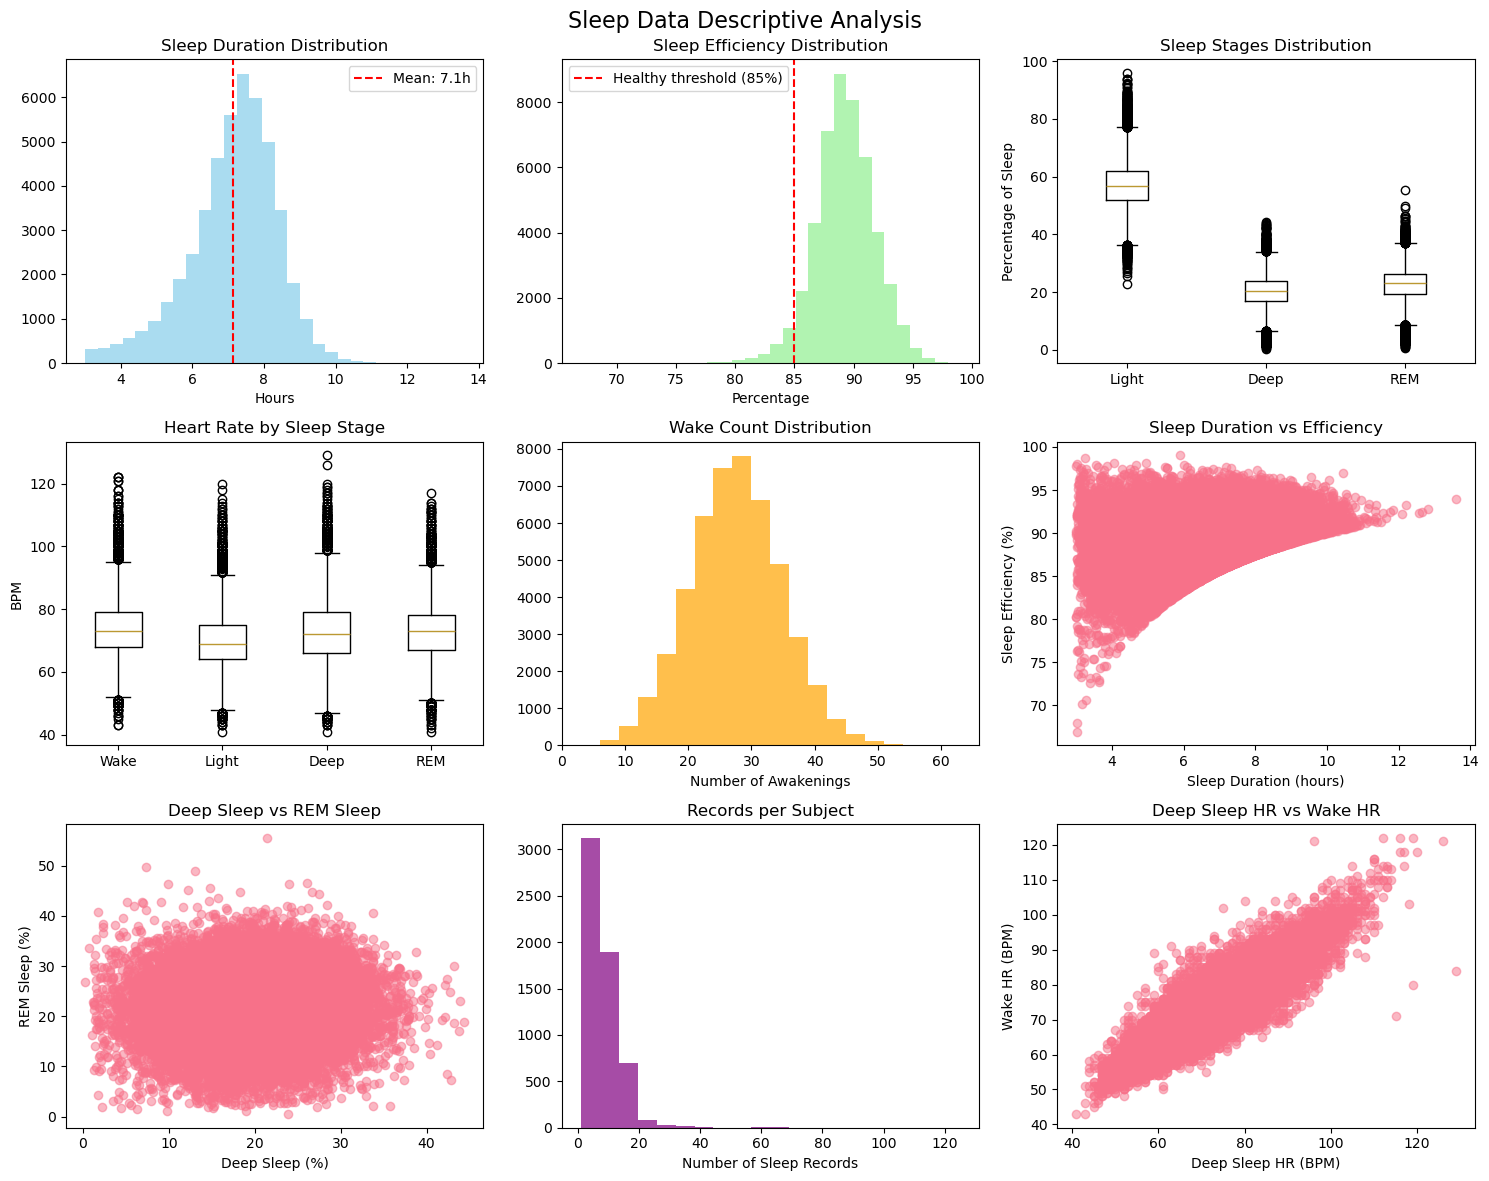

In [32]:
# Create comprehensive plots
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('Sleep Data Descriptive Analysis', fontsize=16)

# 1. Sleep duration distribution
axes[0,0].hist(filtered_sleep_avg['fit_ss_sleepperiod_hours'], bins=30, alpha=0.7, color='skyblue')
axes[0,0].axvline(filtered_sleep_avg['fit_ss_sleepperiod_hours'].mean(), color='red', linestyle='--', label=f'Mean: {filtered_sleep_avg["fit_ss_sleepperiod_hours"].mean():.1f}h')
axes[0,0].set_title('Sleep Duration Distribution')
axes[0,0].set_xlabel('Hours')
axes[0,0].legend()

# 2. Sleep efficiency distribution
axes[0,1].hist(filtered_sleep_avg['sleep_efficiency'], bins=30, alpha=0.7, color='lightgreen')
axes[0,1].axvline(85, color='red', linestyle='--', label='Healthy threshold (85%)')
axes[0,1].set_title('Sleep Efficiency Distribution')
axes[0,1].set_xlabel('Percentage')
axes[0,1].legend()

# 3. Sleep stages boxplot
sleep_stages_data = [filtered_sleep_avg['light_sleep_pct'],
                    filtered_sleep_avg['deep_sleep_pct'],
                    filtered_sleep_avg['rem_sleep_pct']]
axes[0,2].boxplot(sleep_stages_data, labels=['Light', 'Deep', 'REM'])
axes[0,2].set_title('Sleep Stages Distribution')
axes[0,2].set_ylabel('Percentage of Sleep')

# 4. Heart rate by sleep stage
hr_data = [filtered_sleep_avg['fit_ss_avg_hr_wake'],
           filtered_sleep_avg['fit_ss_avg_hr_light'],
           filtered_sleep_avg['fit_ss_avg_hr_deep'],
           filtered_sleep_avg['fit_ss_avg_hr_rem']]
axes[1,0].boxplot(hr_data, labels=['Wake', 'Light', 'Deep', 'REM'])
axes[1,0].set_title('Heart Rate by Sleep Stage')
axes[1,0].set_ylabel('BPM')

# 5. Wake count distribution
axes[1,1].hist(filtered_sleep_avg['fit_ss_wake_count'], bins=20, alpha=0.7, color='orange')
axes[1,1].set_title('Wake Count Distribution')
axes[1,1].set_xlabel('Number of Awakenings')

# 6. Sleep duration vs efficiency scatter
axes[1,2].scatter(filtered_sleep_avg['fit_ss_sleepperiod_hours'],
                 filtered_sleep_avg['sleep_efficiency'], alpha=0.5)
axes[1,2].set_title('Sleep Duration vs Efficiency')
axes[1,2].set_xlabel('Sleep Duration (hours)')
axes[1,2].set_ylabel('Sleep Efficiency (%)')

# 7. Deep sleep vs REM sleep scatter
axes[2,0].scatter(filtered_sleep_avg['deep_sleep_pct'],
                 filtered_sleep_avg['rem_sleep_pct'], alpha=0.5)
axes[2,0].set_title('Deep Sleep vs REM Sleep')
axes[2,0].set_xlabel('Deep Sleep (%)')
axes[2,0].set_ylabel('REM Sleep (%)')

# 8. Records per subject distribution
records_per_subject = filtered_sleep_avg.groupby('src_subject_id').size()
axes[2,1].hist(records_per_subject, bins=20, alpha=0.7, color='purple')
axes[2,1].set_title('Records per Subject')
axes[2,1].set_xlabel('Number of Sleep Records')

# 9. Heart rate wake vs deep correlation
axes[2,2].scatter(filtered_sleep_avg['fit_ss_avg_hr_deep'],
                 filtered_sleep_avg['fit_ss_avg_hr_wake'], alpha=0.5)
axes[2,2].set_title('Deep Sleep HR vs Wake HR')
axes[2,2].set_xlabel('Deep Sleep HR (BPM)')
axes[2,2].set_ylabel('Wake HR (BPM)')

plt.tight_layout()
plt.show()


=== CORRELATION ANALYSIS ===


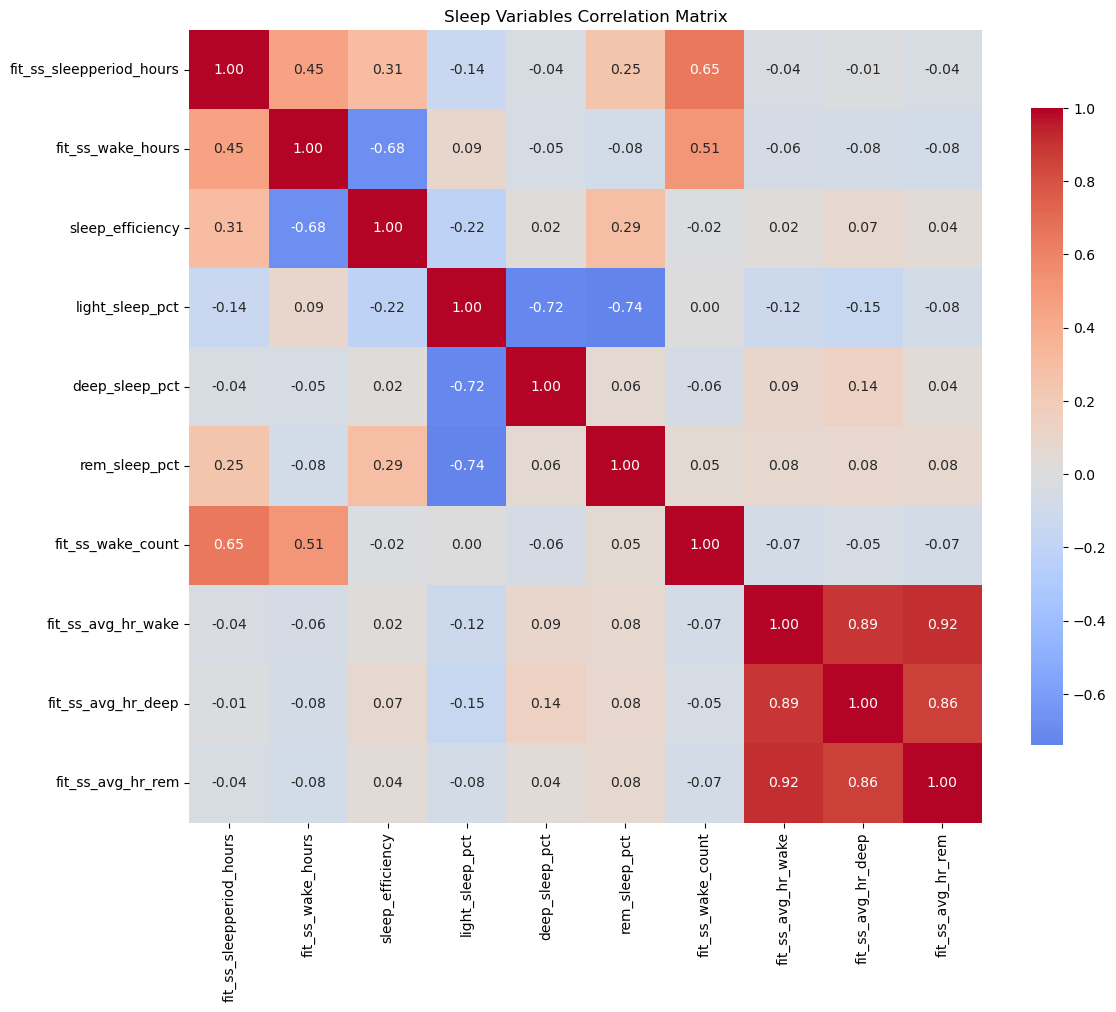

Strongest positive correlations (>0.5):
fit_ss_sleepperiod_hours - fit_ss_wake_count: 0.647
fit_ss_wake_hours - fit_ss_wake_count: 0.514
fit_ss_avg_hr_wake - fit_ss_avg_hr_deep: 0.894
fit_ss_avg_hr_wake - fit_ss_avg_hr_rem: 0.918
fit_ss_avg_hr_deep - fit_ss_avg_hr_rem: 0.863

Strongest negative correlations (<-0.5):
fit_ss_wake_hours - sleep_efficiency: -0.680
light_sleep_pct - deep_sleep_pct: -0.716
light_sleep_pct - rem_sleep_pct: -0.739


In [31]:
print("\n=== CORRELATION ANALYSIS ===")

# Select key variables for correlation
correlation_vars = ['fit_ss_sleepperiod_hours', 'fit_ss_wake_hours', 'sleep_efficiency',
                   'light_sleep_pct', 'deep_sleep_pct', 'rem_sleep_pct', 'fit_ss_wake_count',
                   'fit_ss_avg_hr_wake', 'fit_ss_avg_hr_deep', 'fit_ss_avg_hr_rem']

correlation_matrix = filtered_sleep_avg[correlation_vars].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Sleep Variables Correlation Matrix')
plt.tight_layout()
plt.show()

# Print strongest correlations
print("Strongest positive correlations (>0.5):")
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if corr_val > 0.5:
            print(f"{correlation_matrix.columns[i]} - {correlation_matrix.columns[j]}: {corr_val:.3f}")

print("\nStrongest negative correlations (<-0.5):")
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if corr_val < -0.5:
            print(f"{correlation_matrix.columns[i]} - {correlation_matrix.columns[j]}: {corr_val:.3f}")

In [33]:
# Count records per subject/event combination
records_per_subject_event = filtered_sleep_avg.groupby(['src_subject_id', 'eventname']).size().reset_index(name='day_count')

print("=== 7-DAY FILTER ANALYSIS ===")
print("Distribution of days per subject/event:")
print(records_per_subject_event['day_count'].describe())
print(f"\nSubject/event combinations with <7 days: {(records_per_subject_event['day_count'] < 7).sum()}")
print(f"Subject/event combinations with ≥7 days: {(records_per_subject_event['day_count'] >= 7).sum()}")

# Get subject/event combinations with at least 7 days
valid_combinations = records_per_subject_event[records_per_subject_event['day_count'] >= 7][['src_subject_id', 'eventname']]

# Filter the main dataset to keep only valid combinations
filtered_sleep_7days = filtered_sleep_avg.merge(
    valid_combinations,
    on=['src_subject_id', 'eventname'],
    how='inner'
)

print(f"\nOriginal dataset: {filtered_sleep_avg.shape[0]:,} records")
print(f"After 7-day filter: {filtered_sleep_7days.shape[0]:,} records")
print(f"Records removed: {filtered_sleep_avg.shape[0] - filtered_sleep_7days.shape[0]:,}")
print(f"Subjects remaining: {filtered_sleep_7days['src_subject_id'].nunique():,}")

=== 7-DAY FILTER ANALYSIS ===
Distribution of days per subject/event:
count    5862.000000
mean        8.081883
std         6.426924
min         1.000000
25%         4.000000
50%         7.000000
75%        11.000000
max       125.000000
Name: day_count, dtype: float64

Subject/event combinations with <7 days: 2661
Subject/event combinations with ≥7 days: 3201

Original dataset: 47,376 records
After 7-day filter: 38,003 records
Records removed: 9,373
Subjects remaining: 3,201


In [34]:
# Define the sleep metrics to aggregate
sleep_metrics = [
    'fit_ss_sleepperiod_minutes', 'fit_ss_wake_minutes', 'fit_ss_light_minutes',
    'fit_ss_deep_minutes', 'fit_ss_rem_minutes', 'fit_ss_wake_count',
    'fit_ss_avg_hr_wake', 'fit_ss_avg_hr_light', 'fit_ss_avg_hr_deep', 'fit_ss_avg_hr_rem'
]

# Create comprehensive aggregation functions
def create_sleep_profiles(df):
    """Create comprehensive sleep profiles for each subject/event combination"""

    # Basic aggregations
    agg_dict = {}

    for metric in sleep_metrics:
        agg_dict[f'{metric}_mean'] = (metric, 'mean')
        agg_dict[f'{metric}_std'] = (metric, 'std')
        agg_dict[f'{metric}_min'] = (metric, 'min')
        agg_dict[f'{metric}_max'] = (metric, 'max')
        agg_dict[f'{metric}_median'] = (metric, 'median')

    # Add count and date range
    agg_dict['total_days'] = ('fit_ss_sleepdate', 'count')
    agg_dict['date_range_days'] = ('fit_ss_sleepdate', lambda x: (x.max() - x.min()).days + 1)
    agg_dict['first_date'] = ('fit_ss_sleepdate', 'min')
    agg_dict['last_date'] = ('fit_ss_sleepdate', 'max')

    # Apply aggregation
    sleep_profiles = df.groupby(['src_subject_id', 'eventname']).agg(**agg_dict).reset_index()

    return sleep_profiles

# Create the profiles
sleep_profiles = create_sleep_profiles(filtered_sleep_7days)

print(f"\n=== SLEEP PROFILES CREATED ===")
print(f"Number of individual profiles: {len(sleep_profiles):,}")
print(f"Features per profile: {len(sleep_profiles.columns) - 2}")  # -2 for ID columns
print(f"Profile columns: {sleep_profiles.shape}")


=== SLEEP PROFILES CREATED ===
Number of individual profiles: 3,201
Features per profile: 54
Profile columns: (3201, 56)


In [35]:
# Calculate additional meaningful features
def add_derived_features(profiles):
    """Add clinically relevant derived features"""

    # Sleep efficiency
    profiles['sleep_efficiency_mean'] = ((profiles['fit_ss_sleepperiod_minutes_mean'] -
                                        profiles['fit_ss_wake_minutes_mean']) /
                                       profiles['fit_ss_sleepperiod_minutes_mean'] * 100)

    profiles['sleep_efficiency_std'] = ((profiles['fit_ss_sleepperiod_minutes_std'] +
                                       profiles['fit_ss_wake_minutes_std']) /
                                      profiles['fit_ss_sleepperiod_minutes_mean'] * 100)

    # Sleep stage percentages (mean values)
    total_sleep_mean = (profiles['fit_ss_light_minutes_mean'] +
                       profiles['fit_ss_deep_minutes_mean'] +
                       profiles['fit_ss_rem_minutes_mean'])

    profiles['light_sleep_pct_mean'] = profiles['fit_ss_light_minutes_mean'] / total_sleep_mean * 100
    profiles['deep_sleep_pct_mean'] = profiles['fit_ss_deep_minutes_mean'] / total_sleep_mean * 100
    profiles['rem_sleep_pct_mean'] = profiles['fit_ss_rem_minutes_mean'] / total_sleep_mean * 100

    # Variability measures (coefficient of variation)
    for metric in ['fit_ss_sleepperiod_minutes', 'fit_ss_wake_minutes', 'fit_ss_wake_count']:
        profiles[f'{metric}_cv'] = profiles[f'{metric}_std'] / profiles[f'{metric}_mean']

    # Heart rate variability
    profiles['hr_wake_deep_diff_mean'] = (profiles['fit_ss_avg_hr_wake_mean'] -
                                        profiles['fit_ss_avg_hr_deep_mean'])

    # Sleep regularity (based on standard deviation of sleep timing)
    profiles['sleep_regularity_score'] = 1 / (1 + profiles['fit_ss_sleepperiod_minutes_std'])

    return profiles

# Add derived features
sleep_profiles = add_derived_features(sleep_profiles)

print(f"\nAfter adding derived features: {sleep_profiles.shape}")


After adding derived features: (3201, 66)


In [36]:
# Display summary statistics of the aggregated profiles
print("\n=== INDIVIDUAL SLEEP PROFILE SUMMARY ===")

# Key summary metrics
summary_metrics = [
    'fit_ss_sleepperiod_minutes_mean', 'sleep_efficiency_mean',
    'light_sleep_pct_mean', 'deep_sleep_pct_mean', 'rem_sleep_pct_mean',
    'fit_ss_wake_count_mean', 'fit_ss_avg_hr_wake_mean', 'total_days'
]

print("Summary of aggregated sleep profiles:")
print(sleep_profiles[summary_metrics].describe().round(2))

# Check for missing values in profiles
print(f"\nMissing values in profiles:")
missing_counts = sleep_profiles.isnull().sum()
if missing_counts.sum() > 0:
    print(missing_counts[missing_counts > 0])
else:
    print("No missing values found!")

# Distribution of days per subject
print(f"\nDays per subject distribution:")
print(f"Mean: {sleep_profiles['total_days'].mean():.1f} days")
print(f"Median: {sleep_profiles['total_days'].median():.1f} days")
print(f"Range: {sleep_profiles['total_days'].min()}-{sleep_profiles['total_days'].max()} days")


=== INDIVIDUAL SLEEP PROFILE SUMMARY ===
Summary of aggregated sleep profiles:
       fit_ss_sleepperiod_minutes_mean  sleep_efficiency_mean  \
count                          3201.00                3201.00   
mean                            429.34                  89.40   
std                              40.30                   1.22   
min                             223.64                  83.05   
25%                             404.69                  88.61   
50%                             433.19                  89.40   
75%                             457.06                  90.18   
max                             543.50                  93.97   

       light_sleep_pct_mean  deep_sleep_pct_mean  rem_sleep_pct_mean  \
count               3201.00              3201.00             3201.00   
mean                  56.81                20.26               22.93   
std                    4.45                 2.89                3.07   
min                   41.91                 8.

/var/folders/5_/qxz93g8n1rj5366g0fsr39kr0000gn/T/ipykernel_67717/3145708338.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0,2].boxplot(stage_data, labels=['Light', 'Deep', 'REM'])


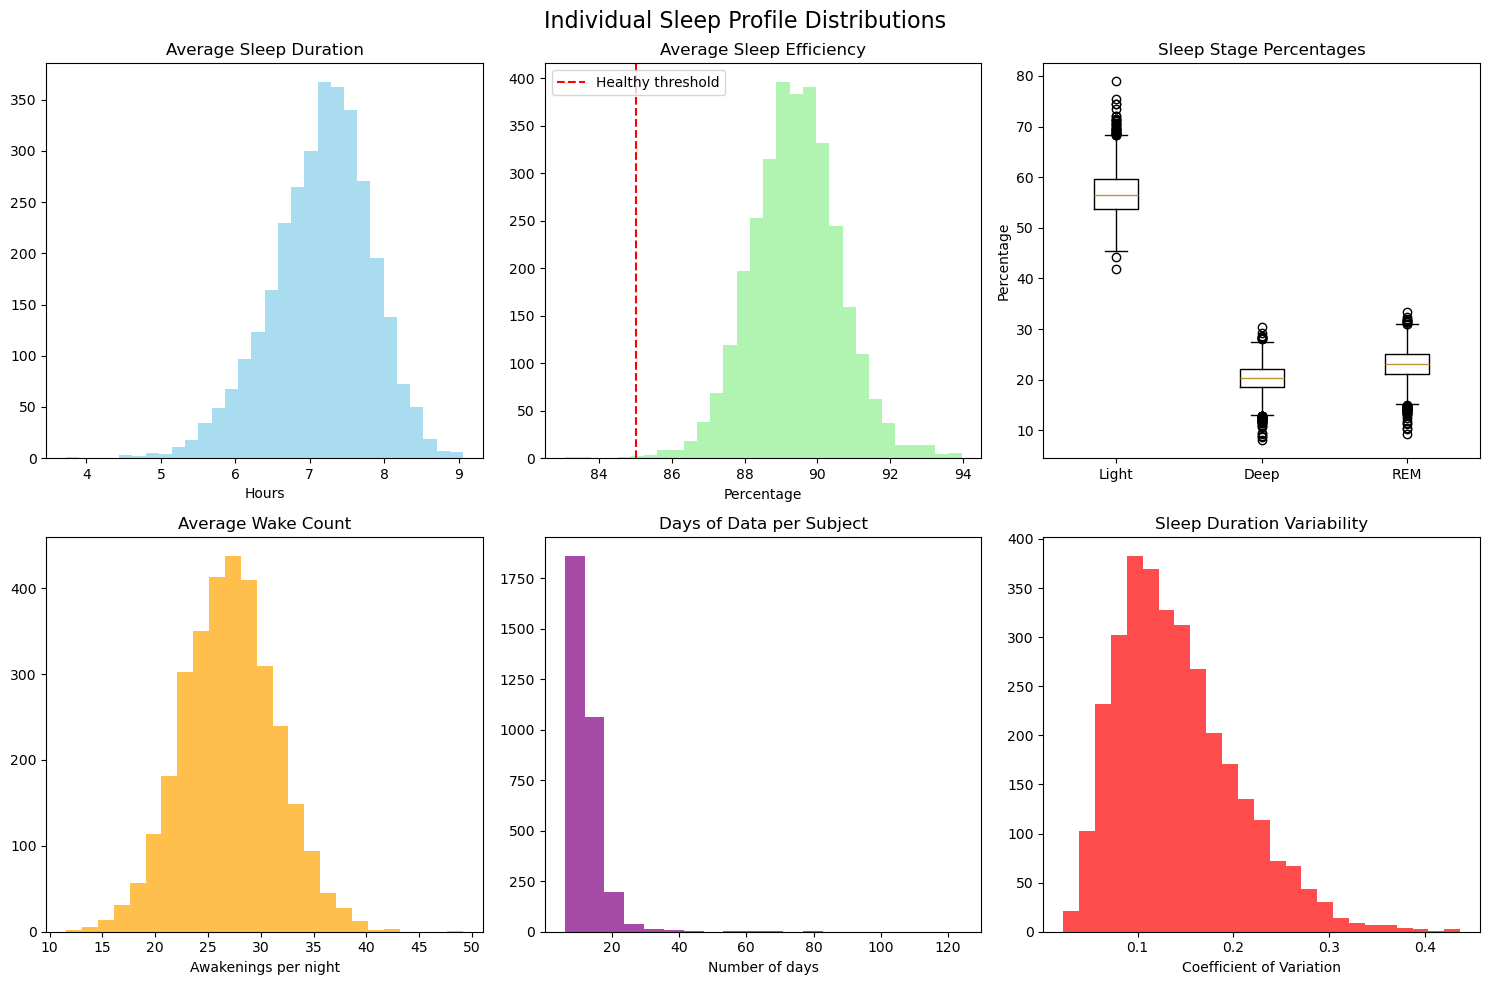


=== FINAL DATASET READY FOR MODELING ===
Individual profiles: 3,201
Features per profile: 64
Ready for depression prediction modeling!


In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create visualization of key profile metrics
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Individual Sleep Profile Distributions', fontsize=16)

# Sleep duration
axes[0,0].hist(sleep_profiles['fit_ss_sleepperiod_minutes_mean']/60, bins=30, alpha=0.7, color='skyblue')
axes[0,0].set_title('Average Sleep Duration')
axes[0,0].set_xlabel('Hours')

# Sleep efficiency
axes[0,1].hist(sleep_profiles['sleep_efficiency_mean'], bins=30, alpha=0.7, color='lightgreen')
axes[0,1].axvline(85, color='red', linestyle='--', label='Healthy threshold')
axes[0,1].set_title('Average Sleep Efficiency')
axes[0,1].set_xlabel('Percentage')
axes[0,1].legend()

# Sleep stage percentages
sleep_stages = ['light_sleep_pct_mean', 'deep_sleep_pct_mean', 'rem_sleep_pct_mean']
stage_data = [sleep_profiles[col] for col in sleep_stages]
axes[0,2].boxplot(stage_data, labels=['Light', 'Deep', 'REM'])
axes[0,2].set_title('Sleep Stage Percentages')
axes[0,2].set_ylabel('Percentage')

# Wake count
axes[1,0].hist(sleep_profiles['fit_ss_wake_count_mean'], bins=25, alpha=0.7, color='orange')
axes[1,0].set_title('Average Wake Count')
axes[1,0].set_xlabel('Awakenings per night')

# Days of data per subject
axes[1,1].hist(sleep_profiles['total_days'], bins=20, alpha=0.7, color='purple')
axes[1,1].set_title('Days of Data per Subject')
axes[1,1].set_xlabel('Number of days')

# Sleep variability
axes[1,2].hist(sleep_profiles['fit_ss_sleepperiod_minutes_cv'], bins=25, alpha=0.7, color='red')
axes[1,2].set_title('Sleep Duration Variability')
axes[1,2].set_xlabel('Coefficient of Variation')

plt.tight_layout()
plt.show()

print(f"\n=== FINAL DATASET READY FOR MODELING ===")
print(f"Individual profiles: {len(sleep_profiles):,}")
print(f"Features per profile: {len(sleep_profiles.columns) - 2}")
print(f"Ready for depression prediction modeling!")

In [43]:
# Add all the derived features to the individual daily records
def add_derived_features_to_daily_data(df):
    """Add derived features to individual daily records"""

    # Convert minutes to hours for easier interpretation
    df['fit_ss_sleepperiod_hours'] = df['fit_ss_sleepperiod_minutes'] / 60
    df['fit_ss_wake_hours'] = df['fit_ss_wake_minutes'] / 60
    df['fit_ss_light_hours'] = df['fit_ss_light_minutes'] / 60
    df['fit_ss_deep_hours'] = df['fit_ss_deep_minutes'] / 60
    df['fit_ss_rem_hours'] = df['fit_ss_rem_minutes'] / 60

    # Sleep efficiency
    df['sleep_efficiency'] = ((df['fit_ss_sleepperiod_minutes'] - df['fit_ss_wake_minutes']) /
                             df['fit_ss_sleepperiod_minutes'] * 100)

    # Sleep stage percentages
    total_sleep_time = (df['fit_ss_light_minutes'] + df['fit_ss_deep_minutes'] + df['fit_ss_rem_minutes'])
    df['light_sleep_pct'] = df['fit_ss_light_minutes'] / total_sleep_time * 100
    df['deep_sleep_pct'] = df['fit_ss_deep_minutes'] / total_sleep_time * 100
    df['rem_sleep_pct'] = df['fit_ss_rem_minutes'] / total_sleep_time * 100

    # Heart rate differences
    df['hr_wake_light_diff'] = df['fit_ss_avg_hr_wake'] - df['fit_ss_avg_hr_light']
    df['hr_wake_deep_diff'] = df['fit_ss_avg_hr_wake'] - df['fit_ss_avg_hr_deep']
    df['hr_wake_rem_diff'] = df['fit_ss_avg_hr_wake'] - df['fit_ss_avg_hr_rem']
    df['hr_light_deep_diff'] = df['fit_ss_avg_hr_light'] - df['fit_ss_avg_hr_deep']
    df['hr_rem_deep_diff'] = df['fit_ss_avg_hr_rem'] - df['fit_ss_avg_hr_deep']

    # Wake frequency (awakenings per hour of sleep)
    df['wake_frequency_per_hour'] = df['fit_ss_wake_count'] / df['fit_ss_sleepperiod_hours']

    return df

# Add derived features to the individual daily data
complete_sleep_data = add_derived_features_to_daily_data(filtered_sleep_7days.copy())

# Simple export
complete_sleep_data.to_csv("../data/clean_data/complete_sleep_data.csv", index=False)

print(f"Complete data exported successfully!")
print(f"File: complete_sleep_data.csv")
print(f"Shape: {complete_sleep_data.shape}")
print(f"Subjects: {complete_sleep_data['src_subject_id'].nunique():,}")
print(f"Total features: {len(complete_sleep_data.columns)}")

Complete data exported successfully!
File: complete_sleep_data.csv
Shape: (38003, 28)
Subjects: 3,201
Total features: 28
